## Reference 
1. https://www.tensorflow.org/tutorials/images/classification
2. https://www.tensorflow.org/tutorials/images/transfer_learning


# Set Up (No need to edit this section)

Imports

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display

import json
import numpy as np

Set up Cloud Directories

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
project_folder_path = '/content/drive/MyDrive/CSC5218_Project_DL'
models_folder_path = os.path.join(project_folder_path, "saved models")
data_folder_path = os.path.join(project_folder_path, "data")
results_folder_path = os.path.join(project_folder_path, "results")

Unzip raw data in colab's vm

In [ ]:
raw_data_path = os.path.join(data_folder_path, 'raw', 'dataset.zip')
print(raw_data_path)

/content/drive/MyDrive/CSC5218_Project_DL/data/raw/dataset.zip


In [ ]:
!unzip $raw_data_path

In [ ]:
!ls

dataset  drive	sample_data


In [ ]:
batch_size = 32
image_height = 224
image_width = 224
dataset_path = 'dataset'

In [ ]:
image_SIZE = (image_height, image_width)

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_path,
  labels='inferred',
  label_mode='categorical',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=image_SIZE,
  batch_size=batch_size)

Found 3064 files belonging to 3 classes.
Using 2452 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_path,
  labels='inferred',
  label_mode='categorical',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=image_SIZE,
  batch_size=batch_size)

Found 3064 files belonging to 3 classes.
Using 612 files for validation.


In [ ]:
val_batches = tf.data.experimental.cardinality(val_ds)

# Create test set from validation set

test_ds = val_ds.take(val_batches // 3)
val_ds = val_ds.skip(val_batches // 3)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 14
Number of test batches: 6


In [ ]:
train_ds.class_names

['Glioma', 'Meningioma', 'Pituitary tumor']

Data augmentation

In [ ]:
# data_augmentation = tf.keras.Sequential([
#   tf.keras.layers.RandomFlip("horizontal_and_vertical"),
#   tf.keras.layers.RandomRotation(0.2)
# ])

Load VGG16 model

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

# preprocess_input = tf.keras.applications.vgg16.preprocess_input

image_SHAPE = image_SIZE + (3,)
base_model = tf.keras.applications.VGG16(input_shape=image_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
inputs = tf.keras.Input(shape=image_SHAPE)
# x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128)(x)
outputs = tf.keras.layers.Dense(3)(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                           

In [ ]:
es = EarlyStopping(monitor='val_categorical_accuracy', mode='max', patience=5,  restore_best_weights=True)

In [ ]:
history = model.fit(train_ds,
                    epochs=100,
                    validation_data=val_ds,
                    callbacks=[es])

Epoch 1/100
77/77 [==============================] - 28s 324ms/step - loss: 0.8286 - categorical_accuracy: 0.7577 - val_loss: 0.4219 - val_categorical_accuracy: 0.8429
Epoch 2/100
77/77 [==============================] - 27s 321ms/step - loss: 0.3622 - categorical_accuracy: 0.8642 - val_loss: 0.5384 - val_categorical_accuracy: 0.8405
Epoch 3/100
77/77 [==============================] - 27s 330ms/step - loss: 0.3030 - categorical_accuracy: 0.8887 - val_loss: 0.4371 - val_categorical_accuracy: 0.8524
Epoch 4/100
77/77 [==============================] - 28s 335ms/step - loss: 0.3653 - categorical_accuracy: 0.8752 - val_loss: 0.3002 - val_categorical_accuracy: 0.9119
Epoch 5/100
77/77 [==============================] - 27s 319ms/step - loss: 0.2244 - categorical_accuracy: 0.9144 - val_loss: 0.2880 - val_categorical_accuracy: 0.9095
Epoch 6/100
77/77 [==============================] - 27s 320ms/step - loss: 0.2099 - categorical_accuracy: 0.9225 - val_loss: 0.4267 - val_categorical_accuracy:

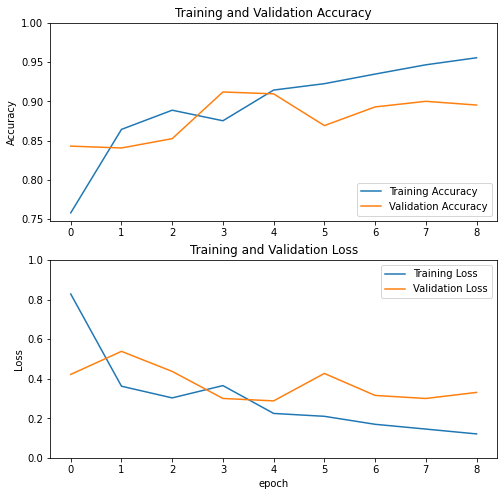

In [ ]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# Evaluation on test dataset
model.evaluate(test_ds)

6/6 [==============================] - 4s 293ms/step - loss: 0.2795 - categorical_accuracy: 0.9323


[0.27950870990753174, 0.9322916865348816]

In [ ]:
predictions = np.array([])
labels =  np.array([])
for x, y in test_ds:
  predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis = -1)])
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

In [ ]:
print(predictions)

[0. 2. 0. 0. 0. 0. 2. 1. 0. 2. 2. 1. 2. 1. 2. 2. 1. 0. 0. 0. 0. 0. 0. 2.
 0. 1. 0. 2. 2. 2. 2. 0. 1. 2. 0. 0. 0. 0. 2. 2. 2. 0. 2. 0. 2. 0. 1. 1.
 1. 0. 0. 0. 1. 0. 1. 2. 0. 0. 0. 0. 1. 1. 2. 2. 2. 0. 0. 0. 1. 0. 0. 0.
 2. 0. 2. 2. 0. 2. 2. 1. 0. 2. 2. 2. 0. 0. 1. 2. 1. 2. 1. 0. 2. 0. 0. 1.
 0. 2. 0. 2. 0. 2. 2. 0. 2. 1. 0. 0. 0. 0. 0. 2. 2. 1. 0. 1. 2. 2. 1. 0.
 2. 1. 0. 1. 0. 1. 0. 0. 2. 0. 2. 1. 1. 0. 1. 0. 2. 2. 0. 0. 2. 2. 0. 0.
 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 2. 2. 1. 2. 0. 1. 2.
 2. 1. 1. 0. 2. 0. 2. 2. 2. 1. 0. 2. 0. 2. 1. 0. 0. 0. 0. 2. 2. 0. 2. 0.]


In [ ]:
print(labels)

[0. 2. 0. 0. 1. 0. 2. 1. 0. 1. 2. 1. 2. 1. 2. 2. 1. 0. 0. 0. 0. 0. 0. 2.
 0. 1. 0. 2. 2. 2. 2. 0. 1. 2. 0. 0. 0. 0. 2. 2. 2. 0. 2. 0. 2. 0. 1. 1.
 1. 0. 0. 0. 1. 0. 0. 2. 0. 0. 0. 0. 1. 1. 2. 2. 2. 0. 0. 1. 0. 0. 0. 0.
 2. 0. 2. 2. 0. 2. 2. 1. 0. 2. 2. 2. 0. 0. 1. 2. 1. 2. 1. 0. 2. 0. 0. 0.
 0. 2. 0. 2. 0. 2. 2. 0. 2. 1. 0. 0. 0. 0. 0. 2. 2. 2. 0. 1. 2. 2. 0. 0.
 2. 0. 0. 2. 0. 1. 0. 1. 1. 0. 2. 1. 1. 0. 1. 0. 2. 2. 0. 0. 2. 2. 0. 0.
 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 2. 2. 1. 2. 0. 1. 2.
 2. 1. 1. 0. 2. 0. 2. 2. 2. 1. 0. 2. 0. 2. 0. 0. 0. 0. 0. 0. 2. 0. 2. 0.]


Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_cm(y_true, y_pred, class_names):
  cm = confusion_matrix(y_true, y_pred, labels=class_names)
  fig, ax = plt.subplots(figsize=(10, 10)) 
  ax = sns.heatmap(
      cm, 
      annot=True, 
      fmt="d", 
      cmap=sns.diverging_palette(230, 30, n=9),
      ax=ax
  )

  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  ax.set_title('Confusion Matrix')
  ax.set_xticklabels(class_names, rotation = 45)
  ax.set_yticklabels(class_names, rotation=0)
  b, t = plt.ylim() # discover the values for bottom and top
  b += 0.5 # Add 0.5 to the bottom
  t -= 0.5 # Subtract 0.5 from the top
  plt.ylim(b, t) # update the ylim(bottom, top) values
  plt.show() # ta-da!

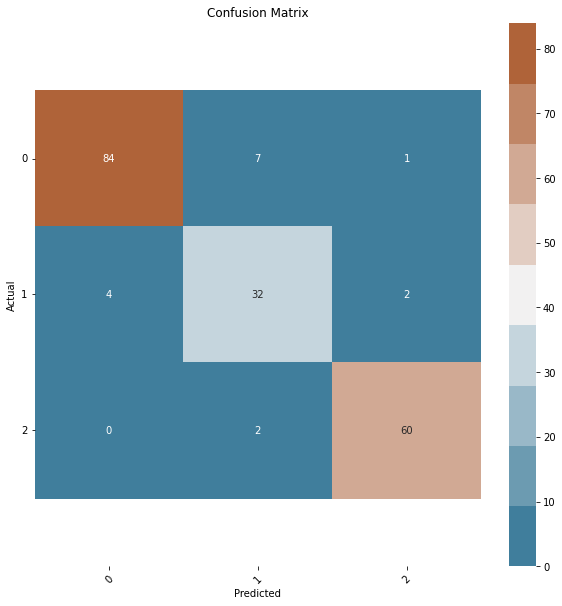

In [ ]:
plot_cm(
  labels,
  predictions,
  [0,1,2]
)

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(labels, predictions)

array([[84,  7,  1],
       [ 4, 32,  2],
       [ 0,  2, 60]])

Precision, recall and F1-score

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(labels, predictions))

              precision    recall  f1-score   support

         0.0       0.95      0.91      0.93        92
         1.0       0.78      0.84      0.81        38
         2.0       0.95      0.97      0.96        62

    accuracy                           0.92       192
   macro avg       0.90      0.91      0.90       192
weighted avg       0.92      0.92      0.92       192



Save model to Drive

In [ ]:
model.save('tl_v2.h5')

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
uploaded = drive.CreateFile({'model': 'tl_v2.h5'})
uploaded.SetContentFile('tl_v2.h5')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1Z6EjNEk7Q26fXr3ZZF-C02VgJFnbcdlh


# Model Specific Set Up (For you to edit)

Model specific paths

In [ ]:
# my_model_name = 'Transfer_learning' # !!! change to your model name !!!
# my_model_version = 1 # !!! change to your model version (if applicable) !!!
# my_model_folder_path = os.path.join(models_folder_path, 
#                                     my_model_name, my_model_name+'_'+str(my_model_version))
# my_model_save_path =  os.path.join(my_model_folder_path,
#                                     my_model_name+'_'+str(my_model_version) + '.h5')
# my_model_checkpoint_path = os.path.join(my_model_folder_path, 'checkpoints')
# print('save model to:')
# print(my_model_save_path)
# print('save checkpoints to:') 
# print(my_model_checkpoint_path)

For loading saved model, saved checkpoints, and setting up future checkpoints

In [ ]:
# Load a model if applicable (for further training)

# model = tf.keras.models.load_model(my_model_save_path)

In [ ]:
# Load the weights if applicable (for further training after defining model)
# Don't need this if using the above cell

# model.load_weights(my_model_checkpoint_path)

In [ ]:
# Create a callback that saves the model's weights every 5 epochs
# Use this callback to train with checkpoints saved on drive
# cp_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=my_model_checkpoint_path, 
#     verbose=1, 
#     save_weights_only=True,
#     save_freq=5*batch_size)

In [ ]:
# Train model and so on...

# Save Model

In [ ]:
# !pip install pyyaml h5py  # Required to save models in HDF5 format

In [ ]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
# model.save(my_model_save_path)
# print(my_model_save_path)